In [1]:
import sys
sys.path.append('../code')
sys.path.append('../externals/SIMNETS-Python/')
import utils, spike_train_functions, lfp_functions

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import pandas as pd
from bycycle import BycycleGroup
from bycycle.utils import get_extrema_df

from scipy.stats import wasserstein_distance
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import simnets

import seaborn as sns


In [2]:
data_path = '../data/'
session_files = {
    # 'SPK121107_MI_PMd_TT_NOGO_ob001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXII-SORTED-01_gNTSNR.mat',
    #     'lfp_file': '30x_downsample.mat',
    #     'map_file': 'SPK_map_MI_PMd.mat'},
    # 'SPK121107_PMv_TT_NOGO_ob001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXII-SORTED-02_gNTSNR.mat',
    #     'lfp_file': '30x_downsample.mat'},
    # 'RUSRH120619_MI_PMd_TT_KG_TC_NOGO_Ob001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXI_corrected_gNTSNR_split.mat',
    #     'lfp_file': '30x_downsample.mat',
    #     'map_file': 'RUS_map_MI_PMd.mat'},
    'SPK121001_MI_PMd_TT_SEQSIM001': {
        'event_file': 'ev_explicit.mat',
        'unit_file': 'DSXII_corrected_gNTSNR_split.mat',
        'lfp_file': '30x_downsample.mat',
        'map_file': 'SPK_map_MI_PMd.mat'},
    # 'SPK121004_MI_PMd_TT_SEQSIM001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXII_corrected_gNTSNR_split.mat',
    #     'lfp_file': '30x_downsample.mat',
    #     'map_file': 'SPK_map_MI_PMd.mat'},
    # 'SPK121005_MI_PMd_TT_SEQSIM001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXII_corrected_gNTSNR_split.mat',
    #     'lfp_file': '30x_downsample.mat',
    #     'map_file': 'SPK_map_MI_PMd.mat'},
    'SPK121001_PMv_TT_SEQSIM001': {
        'event_file': 'ev_explicit.mat',
        'unit_file': 'DSXII_corrected_gNTSNR.mat',
        'lfp_file': '30x_downsample.mat',
        'map_file': 'SPK_map_MI_PMd.mat'},
    # 'SPK121004_PMv_TT_SEQSIM001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXII_corrected_gNTSNR.mat',
    #     'lfp_file': '30x_downsample.mat',
    #     'map_file': 'SPK_map_MI_PMd.mat'},
    # 'SPK121005_PMv_TT_SEQSIM001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXII_corrected_gNTSNR.mat',
    #     'lfp_file': '30x_downsample.mat',
    #     'map_file': 'SPK_map_MI_PMd.mat'}
    
}

In [43]:
def ste_line_plot(ax, data, x, color='C0', label=None):        
    mean_data = np.mean(data, axis=0)
    ste_data = np.std(data, axis=0) 
#     ste_data = np.std(data, axis=0) / np.sqrt(data.shape[0])
    
    plt.fill_between(x=x,y1=mean_data-ste_data, y2=mean_data+ste_data, color=color, alpha=0.3) 
    
    plt.plot(x, mean_data, color=color, label=label)
    

In [45]:
def process_session(session_name, session_dict):
    # Loading files for specific recording session
    # ============================================
    
    # Load spiking data and electrode map
    fpath = f'../data/{session_name}'
    unit_fname = f'{fpath}/{session_name}_{session_dict["unit_file"]}'

    event_fname = f'{fpath}/{session_name}_{session_dict["event_file"]}'
    lfp_fname = f'{fpath}/{session_name}_{session_dict["lfp_file"]}'
    map_fname = f'../data/{session_dict["map_file"]}'
    
    # Load electrode map, single unit spiking, and LFP (.nsx), and experiment data
    mapping_dict = sio.loadmat(map_fname)
    single_unit_dict = sio.loadmat(unit_fname)
    nsx_dict = sio.loadmat(lfp_fname)
    experiment_dict = utils.load_cgid_ev_explicit(event_fname)
    ev_explicit = sio.loadmat(event_fname)
    
    # Process electrode map
    emap_dict = {'label_idx': np.stack(mapping_dict['map_struct'][0]['Num']).squeeze() - 1,
               'row': np.stack(mapping_dict['map_struct'][0]['Row']).squeeze(),
               'col': np.stack(mapping_dict['map_struct'][0]['Column']).squeeze(),
               'area': np.stack(mapping_dict['map_struct'][0]['SubArrayName']).squeeze()}
    emap_df_full = pd.DataFrame(emap_dict)

    # Process single unit data
    single_unit_dict = sio.loadmat(unit_fname)

    sorted_timestamps = single_unit_dict['sorted_timestamps'][0]
    unit_timestamps = [sorted_timestamps[unit_idx].squeeze() for unit_idx in range(len(sorted_timestamps))]
    for unit_idx in range(len(unit_timestamps)):
        if np.size(unit_timestamps[unit_idx]) == 1:
            unit_timestamps[unit_idx] = unit_timestamps[unit_idx].reshape(-1)

    
    num_units = len(unit_timestamps)
    unit_names = np.array(range(num_units))

    unit_electrodes = single_unit_dict['unit_index'][0,:] - 1
    unit_areas = [emap_df_full['area'].values[elec_idx] for elec_idx in unit_electrodes]
    
    # Process experiment timestamps
    go = experiment_dict['go']
    stmv = experiment_dict['stmv']
    contact = experiment_dict['contact']
    obpres = experiment_dict['obpres']
    obj = experiment_dict['ob']
    grip = experiment_dict['grip']
    
    reaction_time = stmv - go
    seq = (go - obpres) > 1 # Identify "sequential" trials
    
    # Process LFP data
    # ================
    samp_freq = 1000
    fs = samp_freq
    nsx_duration = nsx_dict['out'][0][0]['MetaTags'][0][0]['DataDurationSec']

    lfp_data_raw = nsx_dict['out'][0][0]['Data']
    lfp_times_raw = np.linspace(0, nsx_duration, lfp_data_raw.shape[1]).squeeze()
    
    lfp_corr = np.corrcoef(lfp_data_raw)

    win_start = -1
    win_len = 2

    # event_dict = {'go': go}
    # window_dict = {'pre': (win_start, win_len)}

    # event_dict = {'grasppres':grasppres, 'obpres': obpres}
    event_dict = {'go': go, 'stmv': stmv}
    window_dict = {'pre': (win_start, win_len)}


    lfp_data_col = list()
    event_col, event_times_col, window_col, tstart_col = list(), list(), list(), list()
    trial_col, object_col, grip_col, seq_col = list(), list(), list(), list()
    reaction_time_col = list()

    for window_name, (st_offset, max_time) in window_dict.items():
        max_samples = int(max_time * samp_freq)
        for event_name, event_ts in event_dict.items():
            object_col.extend(obj)
            grip_col.extend(grip)
            seq_col.extend(seq)
            reaction_time_col.extend(reaction_time)
            for trial_idx, event_time in enumerate(event_ts):
                    event_col.append(event_name)
                    event_times_col.append(event_time)
                    window_col.append(window_name)
                    trial_col.append(trial_idx)

                    tstart = event_time + st_offset
                    tstop = tstart + max_time
                    start_idx = np.argmin(np.abs(lfp_times_raw - tstart))
                    stop_idx = start_idx + max_samples

                    tstart_col.append(tstart)

                    lfp_windowed = lfp_data_raw[:, start_idx:stop_idx]
                    lfp_data_col.append(lfp_windowed)

    lfp_dict = {'event': event_col, 'window': window_col, 'lfp': lfp_data_col, 'event_time': event_times_col,
                'object': object_col, 'seq': seq_col, 'reaction_time': reaction_time_col,
                'grip': grip_col, 'trial': trial_col, 'tstart': tstart_col}

    lfp_df = pd.DataFrame(lfp_dict)

    # Extract beta oscillations with cycle by cycle analysis
    # ======================================================
    lfp_data_array = np.stack(lfp_df['lfp'].values)
    
    noise_channels = np.where(np.mean(lfp_corr,axis=0) < 0.2)[0]
    
    times = np.linspace(win_start, win_start + win_len, lfp_data_array.shape[2])

    res_dict = {'experiment_dict': experiment_dict, 'lfp_df': lfp_df,
                'unit_timestamps': unit_timestamps, 'event_dict': event_dict,
                'window_dict': window_dict,
                'noise_channels': noise_channels, 'fs': fs, 'single_unit_dict': single_unit_dict,
                'unit_areas': unit_areas, 'unit_electrodes': unit_electrodes, 'ev_explicit': ev_explicit,
                'times': times
                # 'lfp_data_array': lfp_data_array, 'lfp_corr': lfp_corr,
    
               }

    return res_dict

In [46]:
processed_session = dict()
for session_name, session_dict in session_files.items():
    print(session_name)
    res_dict = process_session(session_name, session_dict)
    processed_session[session_name] = res_dict

SPK121001_MI_PMd_TT_SEQSIM001
SPK121001_PMv_TT_SEQSIM001


In [89]:
session_names = list(processed_session.keys())
res_dict = processed_session[session_names[0]]

lfp_df = res_dict['lfp_df']
event_dict, window_dict = res_dict['event_dict'], res_dict['window_dict']
times = res_dict['times']
print(f"Noise Channels: {res_dict['noise_channels']}")

Noise Channels: []


/tmp/ipykernel_2845988/1359438625.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


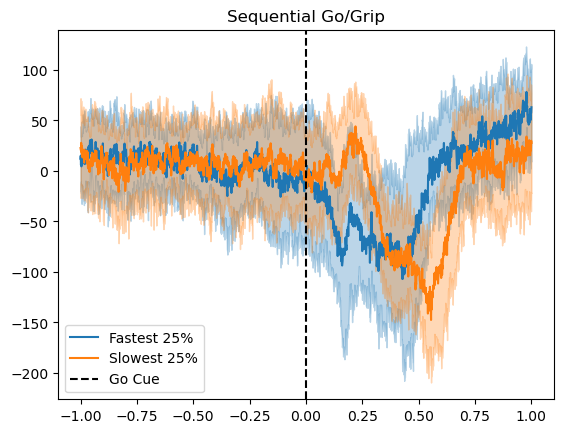

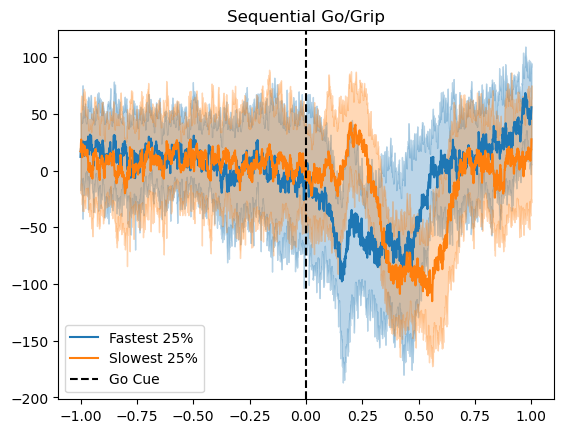

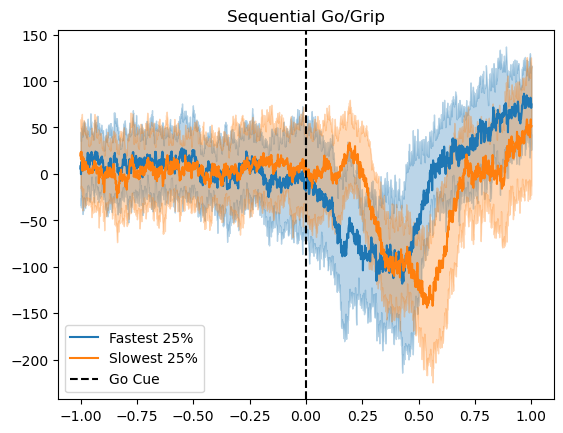

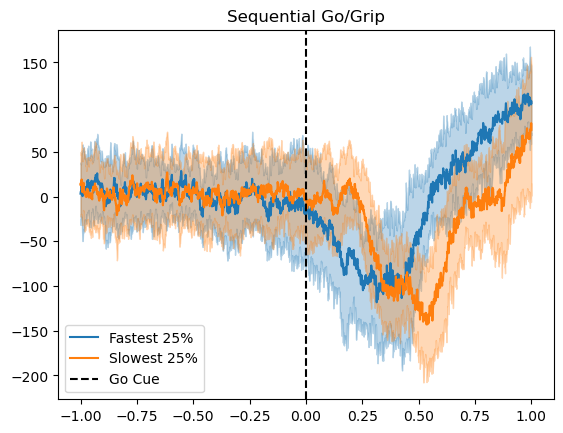

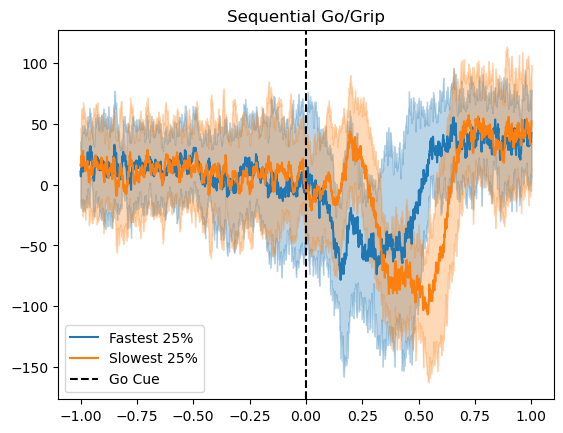

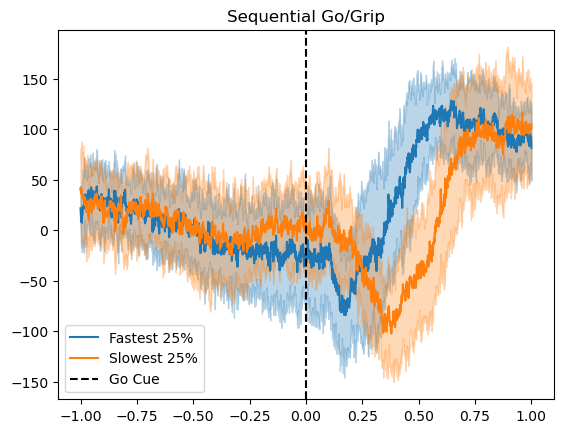

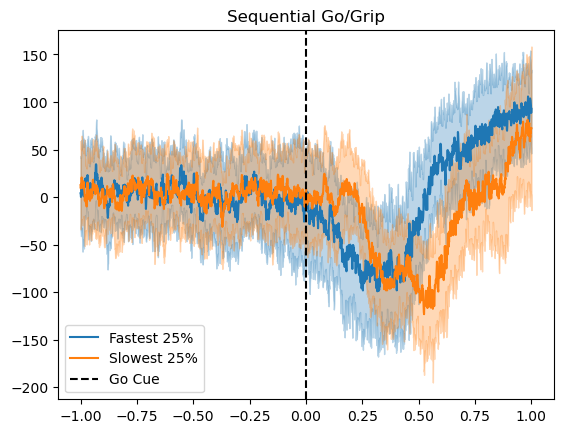

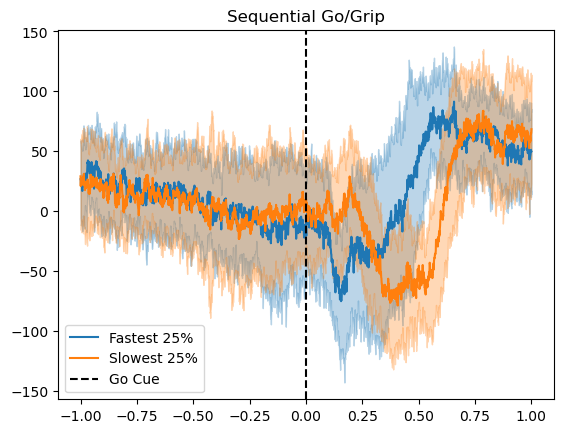

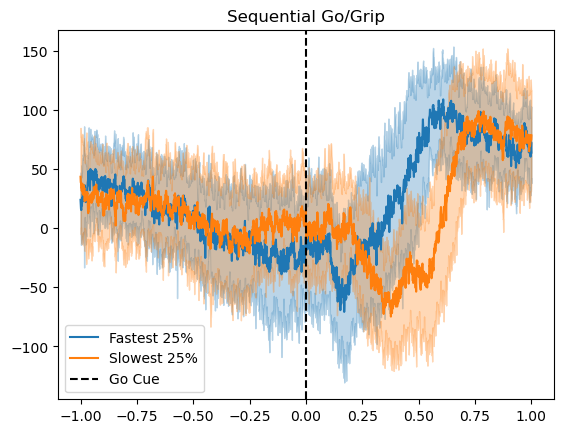

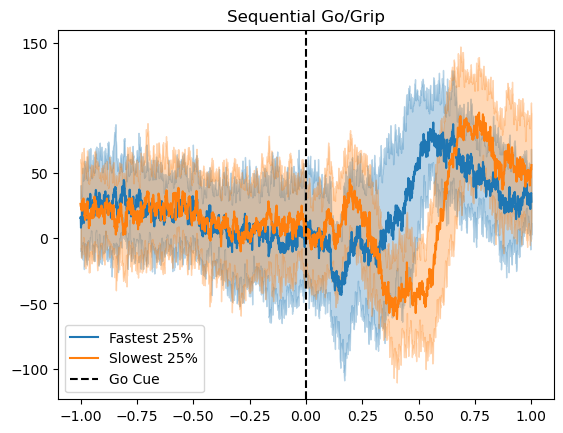

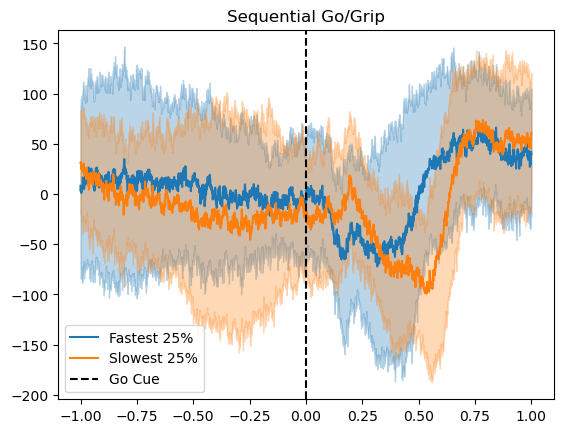

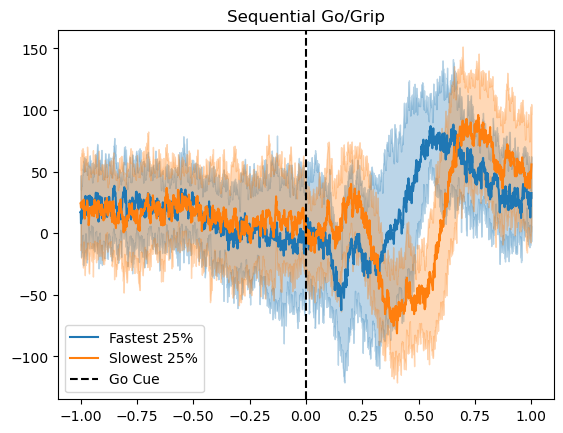

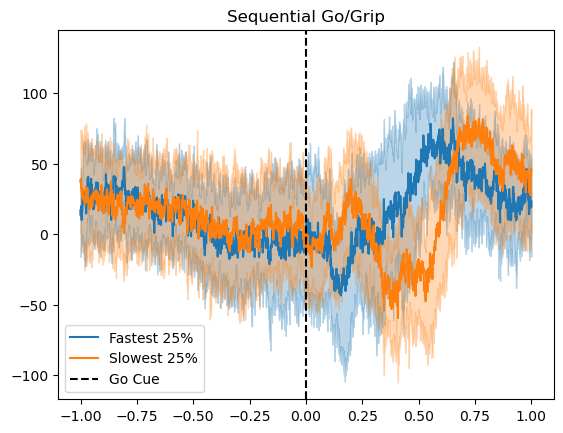

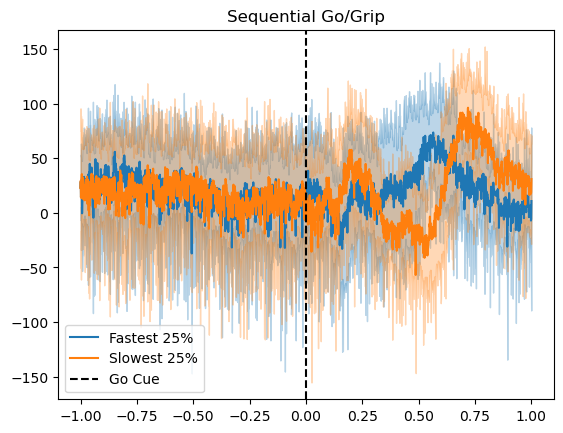

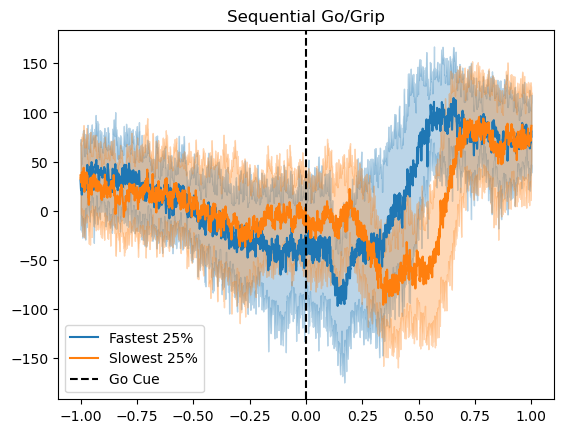

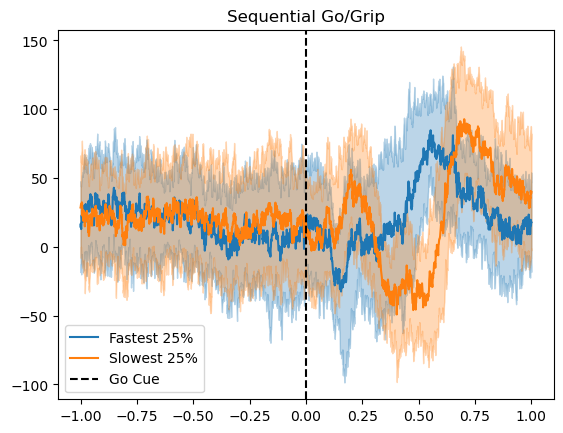

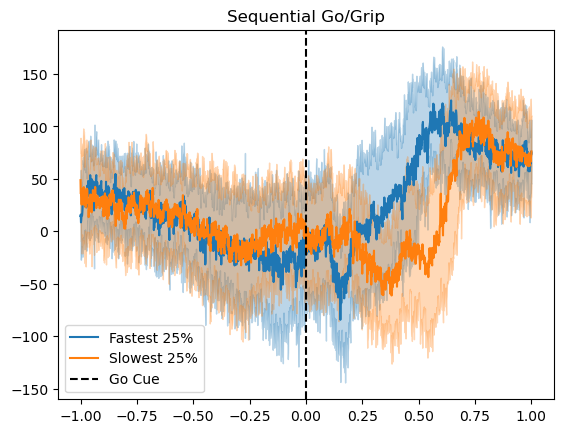

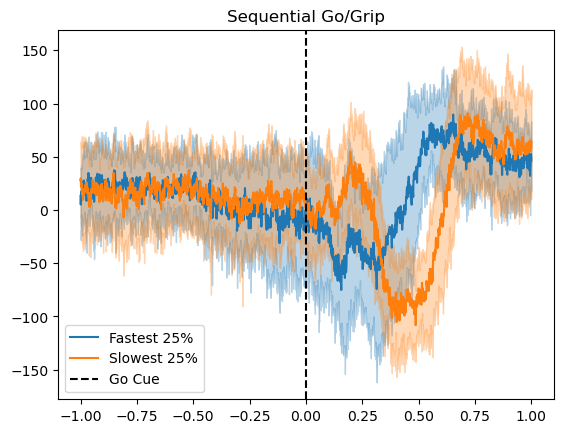

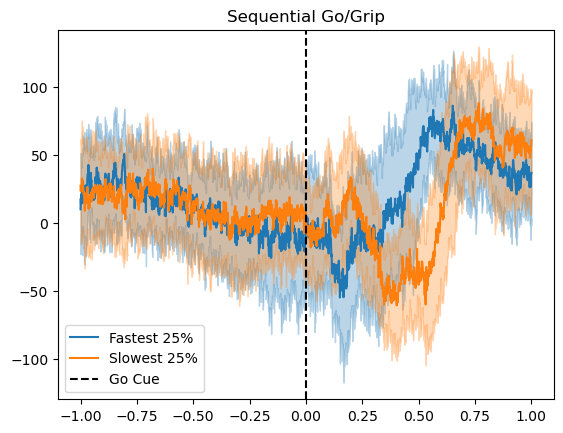

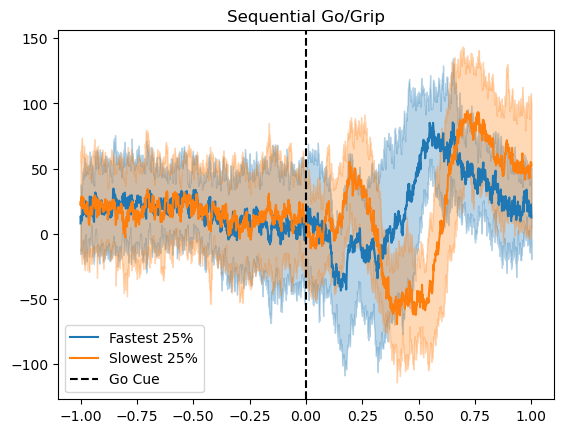

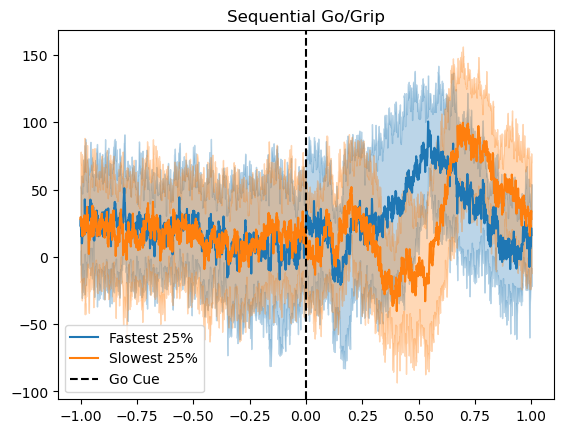

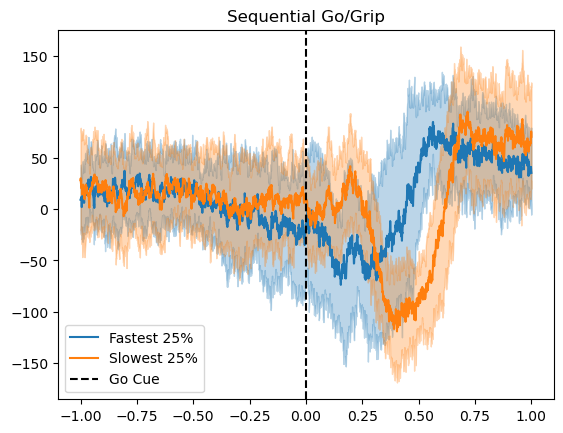

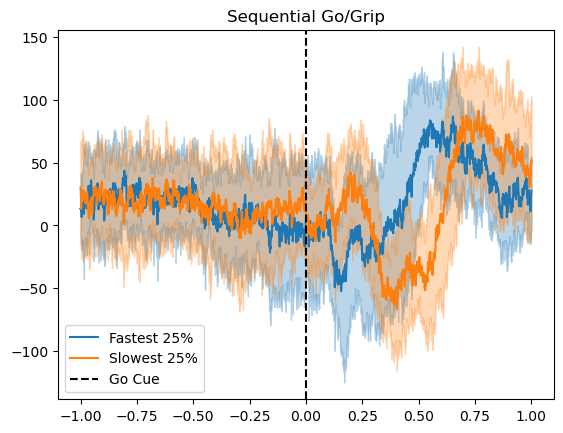

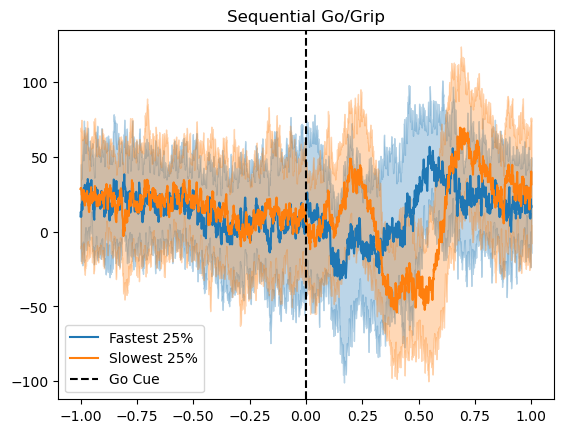

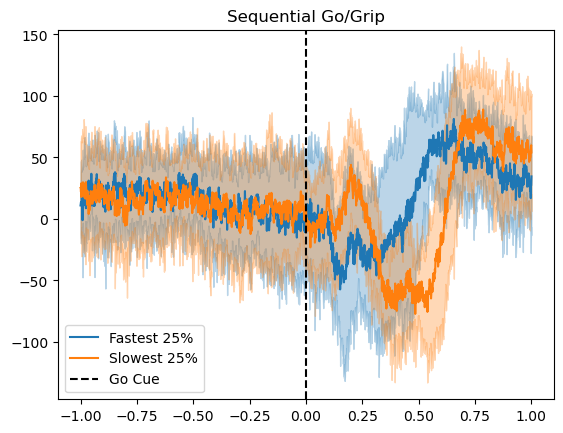

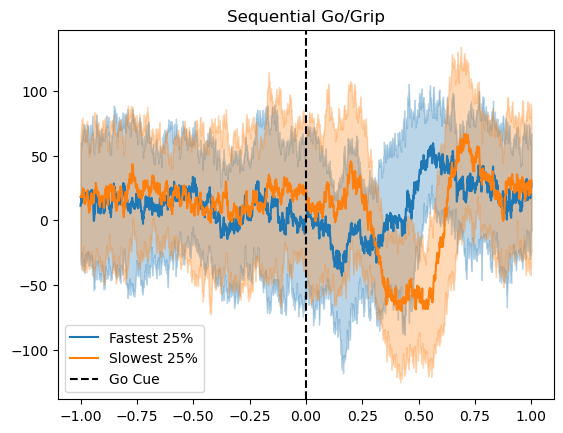

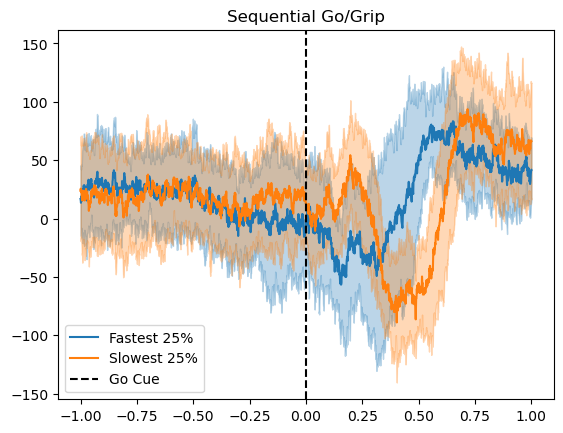

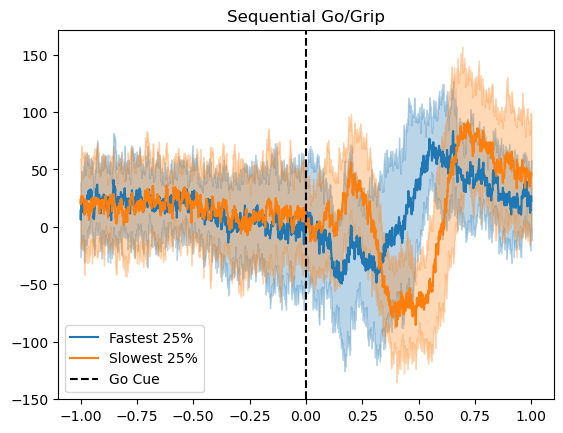

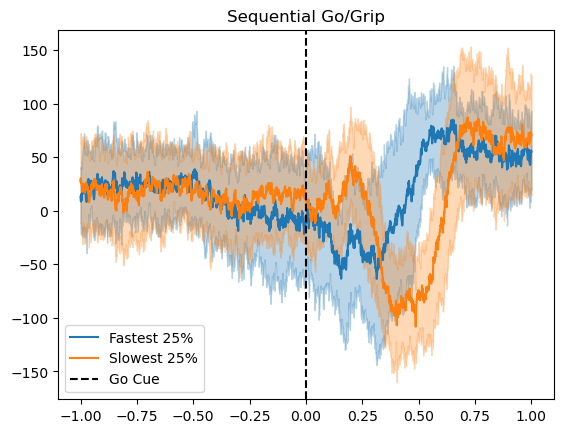

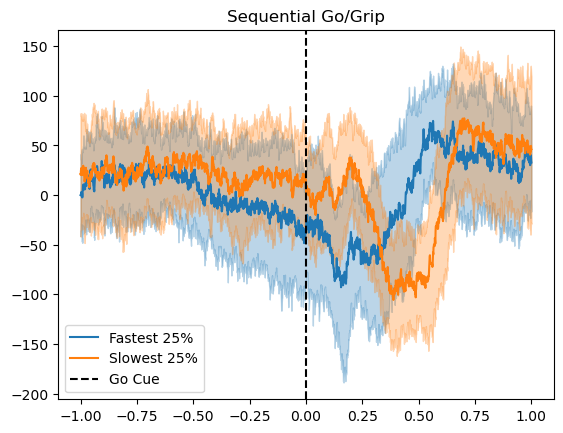

In [132]:
filter_df = lfp_df.copy()
event = 'go'
window_name = 'pre'
win_start, win_len = window_dict[window_name]

filter_df = filter_df[filter_df['seq'] == True]
filter_df = filter_df[filter_df['event'] == event]
filter_df = filter_df[filter_df['window'] == window_name]
# filter_df = filter_df[filter_df['reaction_time'] < 1.0]

electrode_idx = 3
for electrode_idx in range(30):
    filter_feature = 'reaction_time'
    mask1 = filter_df[filter_feature] < np.percentile(filter_df[filter_feature].values, 25)
    mask2 = filter_df[filter_feature] > np.percentile(filter_df[filter_feature].values, 75)

    cond1_lfp = np.stack(filter_df['lfp'].values)[mask1, electrode_idx, :]
    cond2_lfp = np.stack(filter_df['lfp'].values)[mask2, electrode_idx, :]

    fig, ax = plt.subplots()

    ste_line_plot(ax, cond1_lfp, x=times, color='C0', label='Fastest 25%')
    ste_line_plot(ax, cond2_lfp, x=times, color='C1', label='Slowest 25%')
    ax.axvline(x=0.0, color='k', label='Go Cue', linestyle='--')
    # plt.xlim(-0.25, 0.25)
    plt.legend(loc='lower left')
    plt.title('Sequential Go/Grip')

Text(0.5, 1.0, 'Sequential Go/Grip')

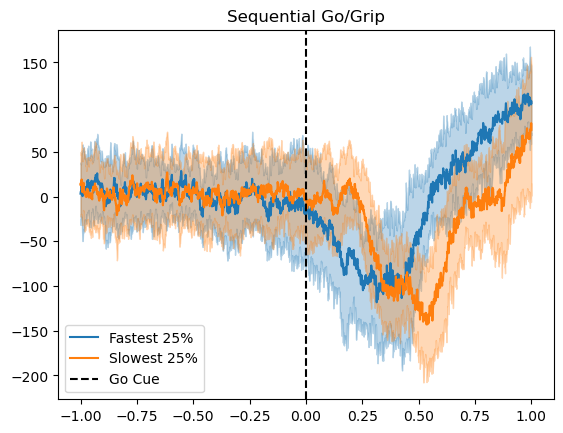

In [131]:
fig, ax = plt.subplots()

ste_line_plot(ax, cond1_lfp, x=times, color='C0', label='Fastest 25%')
ste_line_plot(ax, cond2_lfp, x=times, color='C1', label='Slowest 25%')
ax.axvline(x=0.0, color='k', label='Go Cue', linestyle='--')
# plt.xlim(-0.25, 0.25)
plt.legend(loc='lower left')
plt.title('Sequential Go/Grip')

In [ ]:
# Calculate TFRs for spectral events

freqs = np.arange(2,80,2)   # fequency values (Hz) over which to calculate TFR
#times = np.arange(n_times) / samp_freq  # seconds
event_band = [13, 30]  # beta band (Hz)
# event_band = [8, 12]  # alpha band (Hz)
# event_band = [30, 80]  # gamma band (Hz)

thresh_FOM = 3.0  # factor-of-the-median threshold

window = [0.0, 2]

e_idx = 100
lfp_data = np.stack(lfp_df['lfp'].values)[:,e_idx,:]
times = np.linspace(0, lfp_data.shape[1] / samp_freq, lfp_data.shape[1])

times_mask = np.logical_and(times >= window[0], times < window[1])
times = times[:np.sum(times_mask)]
lfp_data = lfp_data[:, times_mask]

tfrs = se.tfr(lfp_data[:,:], freqs, samp_freq)
spec_events = se.find_events(tfr=tfrs, times=times, freqs=freqs,
                             event_band=event_band, threshold_FOM=thresh_FOM)

event_df_list = list()
for trial_idx, trial_events in enumerate(spec_events):
    for event_idx, event_dict in enumerate(trial_events):
        event_dict['trial'] = trial_idx
        event_df_list.append(event_dict)
event_df = pd.DataFrame(event_df_list).groupby('trial').agg(list).reset_index()

def index_max_event(row, *cols):
    event_idx = row[cols[0]]
    peak_times = row[cols[1]]
    return peak_times[event_idx]

event_df['event_count'] = event_df['Peak Power'].map(len)
event_df['max_event_power'] = event_df['Peak Power'].map(np.max)
event_df['max_event_idx'] = event_df['Peak Power'].map(np.argmax)
event_df['max_event_time'] = event_df.apply(index_max_event, args=('max_event_idx', 'Peak Time'), axis=1)
event_df['max_freq_span'] = event_df.apply(index_max_event, args=('max_event_idx', 'Frequency Span'), axis=1)
event_df['max_peak_freq'] = event_df.apply(index_max_event, args=('max_event_idx', 'Peak Frequency'), axis=1)
event_df['max_event_duration'] = event_df.apply(index_max_event, args=('max_event_idx', 'Event Duration'), axis=1)

event_df['avg_event_power'] = event_df['Peak Power'].map(np.mean)
event_df['normal_avg_event_power'] = event_df['Normalized Peak Power'].map(np.mean)

lfp_df = lfp_df.merge(event_df, how='left', on='trial')
print(np.sum(np.isnan(lfp_df['event_count'])), 'trials with no events')

lfp_df['Peak Time'] = lfp_df['Peak Time'].map(np.array)
lfp_df['min_event_dist'] = (lfp_df['event_time'] - (lfp_df['Peak Time'] + lfp_df['tstart'])).map(np.min)

lfp_df = lfp_df.dropna()